In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import rpy2 as rp
import rpy2.robjects as ro
import umap.umap_ as umap
import pyreadr
import os
import time
import h5py
# import mmdet
import scanpy
# import ssam
import pickle
import random
# import pyarrow
import dgl
import ast
import cv2


from tqdm import tqdm

from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score, matthews_corrcoef, mean_squared_error

# from captum.attr import IntegratedGradients
# from captum.attr import LayerConductance
# from captum.attr import NeuronConductance

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F

# import torch_geometric

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms, utils

from skimage import io
from skimage import img_as_float
from scipy import ndimage

# from ssam.utils import corr, calc_ctmap, calc_corrmap, flood_fill, calc_kde
from scipy.spatial.distance import cdist

from collections import OrderedDict

from packaging import version
import subprocess

In [2]:
torch.__version__

'2.0.1'

<h3>Dataset batch preprocess</h3>

In [3]:
class TumorDatasetAll(Dataset):
    
    def __init__(self, instance , root_dir, transform=None):
        self.instance = instance
        # self.labels_frame = np.array(pd.read_csv(csv_file, skiprows=1, sep=',', header=None)).astype(int)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return self.instance.shape[-1]

    def __getitem__(self, idx):
        
        img = np.zeros(shape=(1, 270 , 220),dtype=np.double)
        img = self.instance[idx,...]
        
        # label = np.array([self.labels_frame[idx, 1]-1])
        train_sample = {'image': img}
        
        if self.transform:
            train_sample = self.transform(train_sample)
            
        return train_sample
    
class TumorDatasetTrain(Dataset):
    
    def __init__(self, instance , root_dir, transform=None):
        self.instance = instance
        # self.labels_frame = np.array(pd.read_csv(csv_file, skiprows=1, sep=',', header=None)).astype(int)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return self.instance.shape[-1]

    def __getitem__(self, idx):
        
        img = np.zeros(shape=(1, 270 , 220),dtype=np.double)
        img = self.instance[idx,...]
        
        # label = np.array([self.labels_frame[idx, 1]-1])
        train_sample = {'image': img}
        
        if self.transform:
            train_sample = self.transform(train_sample)
            
        return train_sample

class TumorDatasetTest(Dataset):
    
    def __init__(self, instance , root_dir, transform=None):
        self.instance = instance
        # self.labels_frame = np.array(pd.read_csv(csv_file, skiprows=1, sep=',', header=None)).astype(int)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return self.instance.shape[-1]

    def __getitem__(self, idx):
        
        img = np.zeros(shape=(1, 270 , 220),dtype=np.double)
        img = self.instance[idx, ...]
        
        # label = np.array([self.labels_frame[idx, 1]-1])
        test_sample = {'image': img }
        
        if self.transform:
            test_sample = self.transform(test_sample)
        return test_sample
    
class ToTensor(object):

    def __call__(self, sample):
        image = sample['image']
        return {'image': torch.from_numpy(image)}

In [4]:
spat_507 = np.load('dataset/datapoints/com4m_encoded_507_unfil.npy')
spat_507 = spat_507.reshape((spat_507.shape[0],spat_507.shape[-1]))
spat_672 = np.load('dataset/datapoints/com4m_encoded_672_unfil.npy')
spat_672 = spat_672.reshape((spat_672.shape[0],spat_672.shape[-1]))
spat_673 = np.load('dataset/datapoints/com4m_encoded_673_unfil.npy')
spat_673 = spat_673.reshape((spat_673.shape[0],spat_673.shape[-1]))

In [5]:
spat_all = np.concatenate((spat_507, spat_672, spat_673), axis=0)
batch = np.concatenate((np.repeat(0, spat_507.shape[0]), np.repeat(1, spat_672.shape[0]), np.repeat(2, spat_673.shape[0])))

In [6]:
spat_all.shape

(100614, 1000)

In [7]:
batch.shape

(100614,)

In [13]:
umap_model = umap.UMAP(n_neighbors = 2,min_dist = 0.99)
umap_embedding = umap_model.fit_transform(spat_all)

/opt/conda/lib/python3.10/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/opt/conda/lib/python3.10/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/opt/conda/lib/python3.10/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/opt/conda/lib/python3.10/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenve

In [24]:
umap_embedding.shape

(100614, 2)

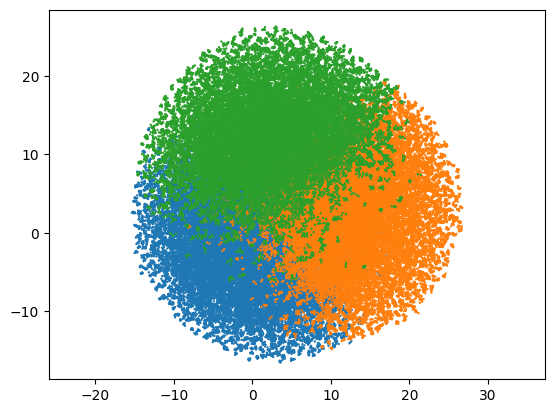

In [14]:
import seaborn as sns
plt.scatter(
    umap_embedding[:, 0],
    umap_embedding[:, 1],
    c=[sns.color_palette()[x] for x in batch],
    s=0.5
)
plt.gca().set_aspect('equal', 'datalim')

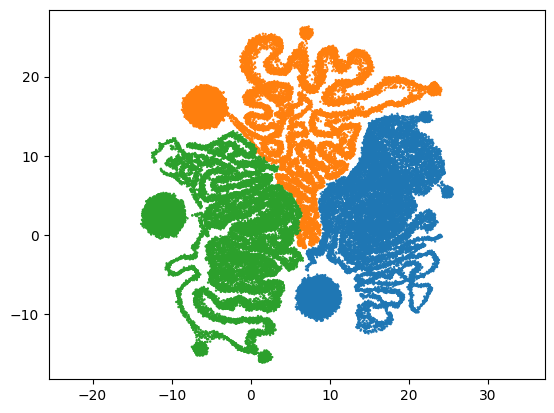

In [11]:
import seaborn as sns
plt.scatter(
    umap_embedding[:, 0],
    umap_embedding[:, 1],
    c=[sns.color_palette()[x] for x in batch],
    s=0.5
)
plt.gca().set_aspect('equal', 'datalim')

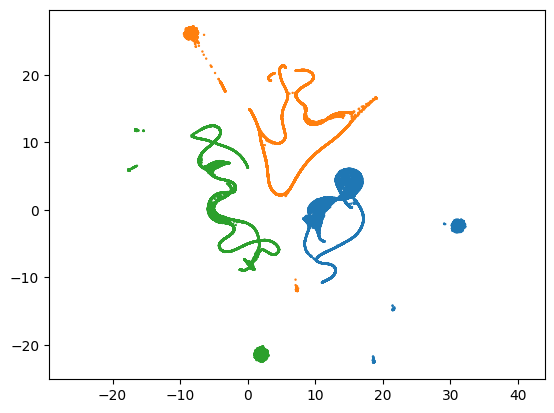

In [9]:
import seaborn as sns
plt.scatter(
    umap_embedding[:, 0],
    umap_embedding[:, 1],
    c=[sns.color_palette()[x] for x in batch],
    s=0.5
)
plt.gca().set_aspect('equal', 'datalim')

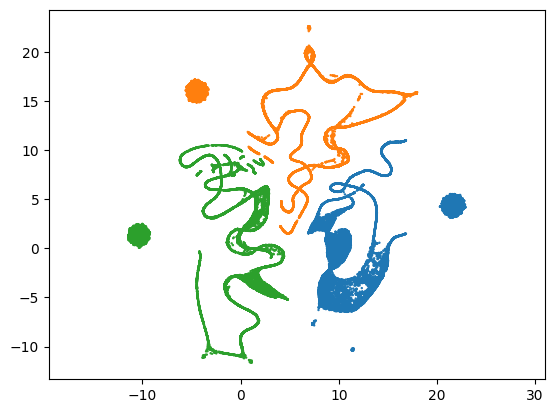

In [26]:
import seaborn as sns
plt.scatter(
    umap_embedding[:, 0],
    umap_embedding[:, 1],
    c=[sns.color_palette()[x] for x in batch],
    s=0.5
)
plt.gca().set_aspect('equal', 'datalim')

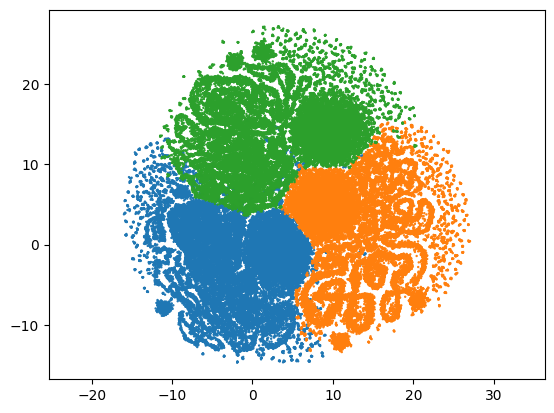

In [28]:
import seaborn as sns
plt.scatter(
    umap_embedding[:, 0],
    umap_embedding[:, 1],
    c=[sns.color_palette()[x] for x in batch],
    s=0.5
)
plt.gca().set_aspect('equal', 'datalim')

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)

In [25]:
pca_data = pca.fit_transform(spat_all)

In [27]:
pca_data.shape

(100614, 2)

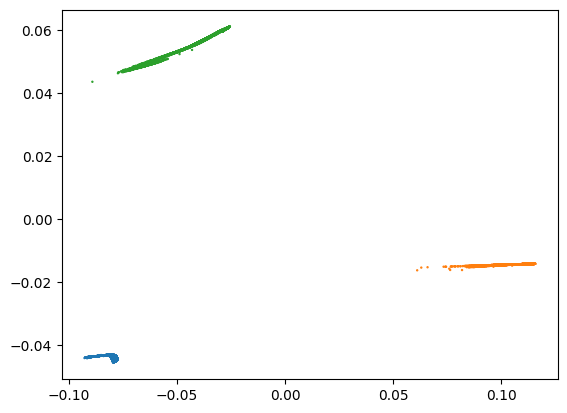

In [26]:
plt.scatter(pca_data[:, 0], pca_data[:, 1],c=[sns.color_palette()[x] for x in batch], s = 0.5)

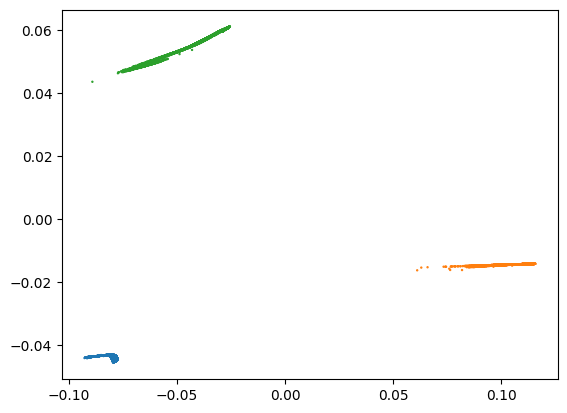

In [19]:
plt.scatter(pca_data[:, 0], pca_data[:, 1],c=[sns.color_palette()[x] for x in batch], s = 0.5)

In [4]:
mat_151507 = pyreadr.read_r('dataset/df_logcount_507.rds')
mat_151672 = pyreadr.read_r('dataset/df_logcount_672.rds')
mat_151673 = pyreadr.read_r('dataset/df_logcount_673.rds')
df_151507 = mat_151507[None]
df_151672 = mat_151672[None]
df_151673 = mat_151673[None]
combined_507_672 = pd.concat([df_151507,df_151672],axis=1)
combined_all = pd.concat([combined_507_672,df_151673],axis=1)

In [5]:
directory1 = 'dataset/datapoints/unfil_151507'
# directory1 = 'dataset/datapoints/151507'
directory2 = 'dataset/datapoints/unfil_151672'
directory3 = 'dataset/datapoints/unfil_151673'
filenames1 = os.listdir(directory1)
filenames2 = os.listdir(directory2)
filenames3 = os.listdir(directory3)
filenames1[:3]

['ENSG00000242258.npy', 'ENSG00000277630.npy', 'ENSG00000138892.npy']

In [6]:
len(filenames2)

33538

(270, 220)
(280, 220)
(270, 220)
(280, 220)
(270, 220)
(280, 220)


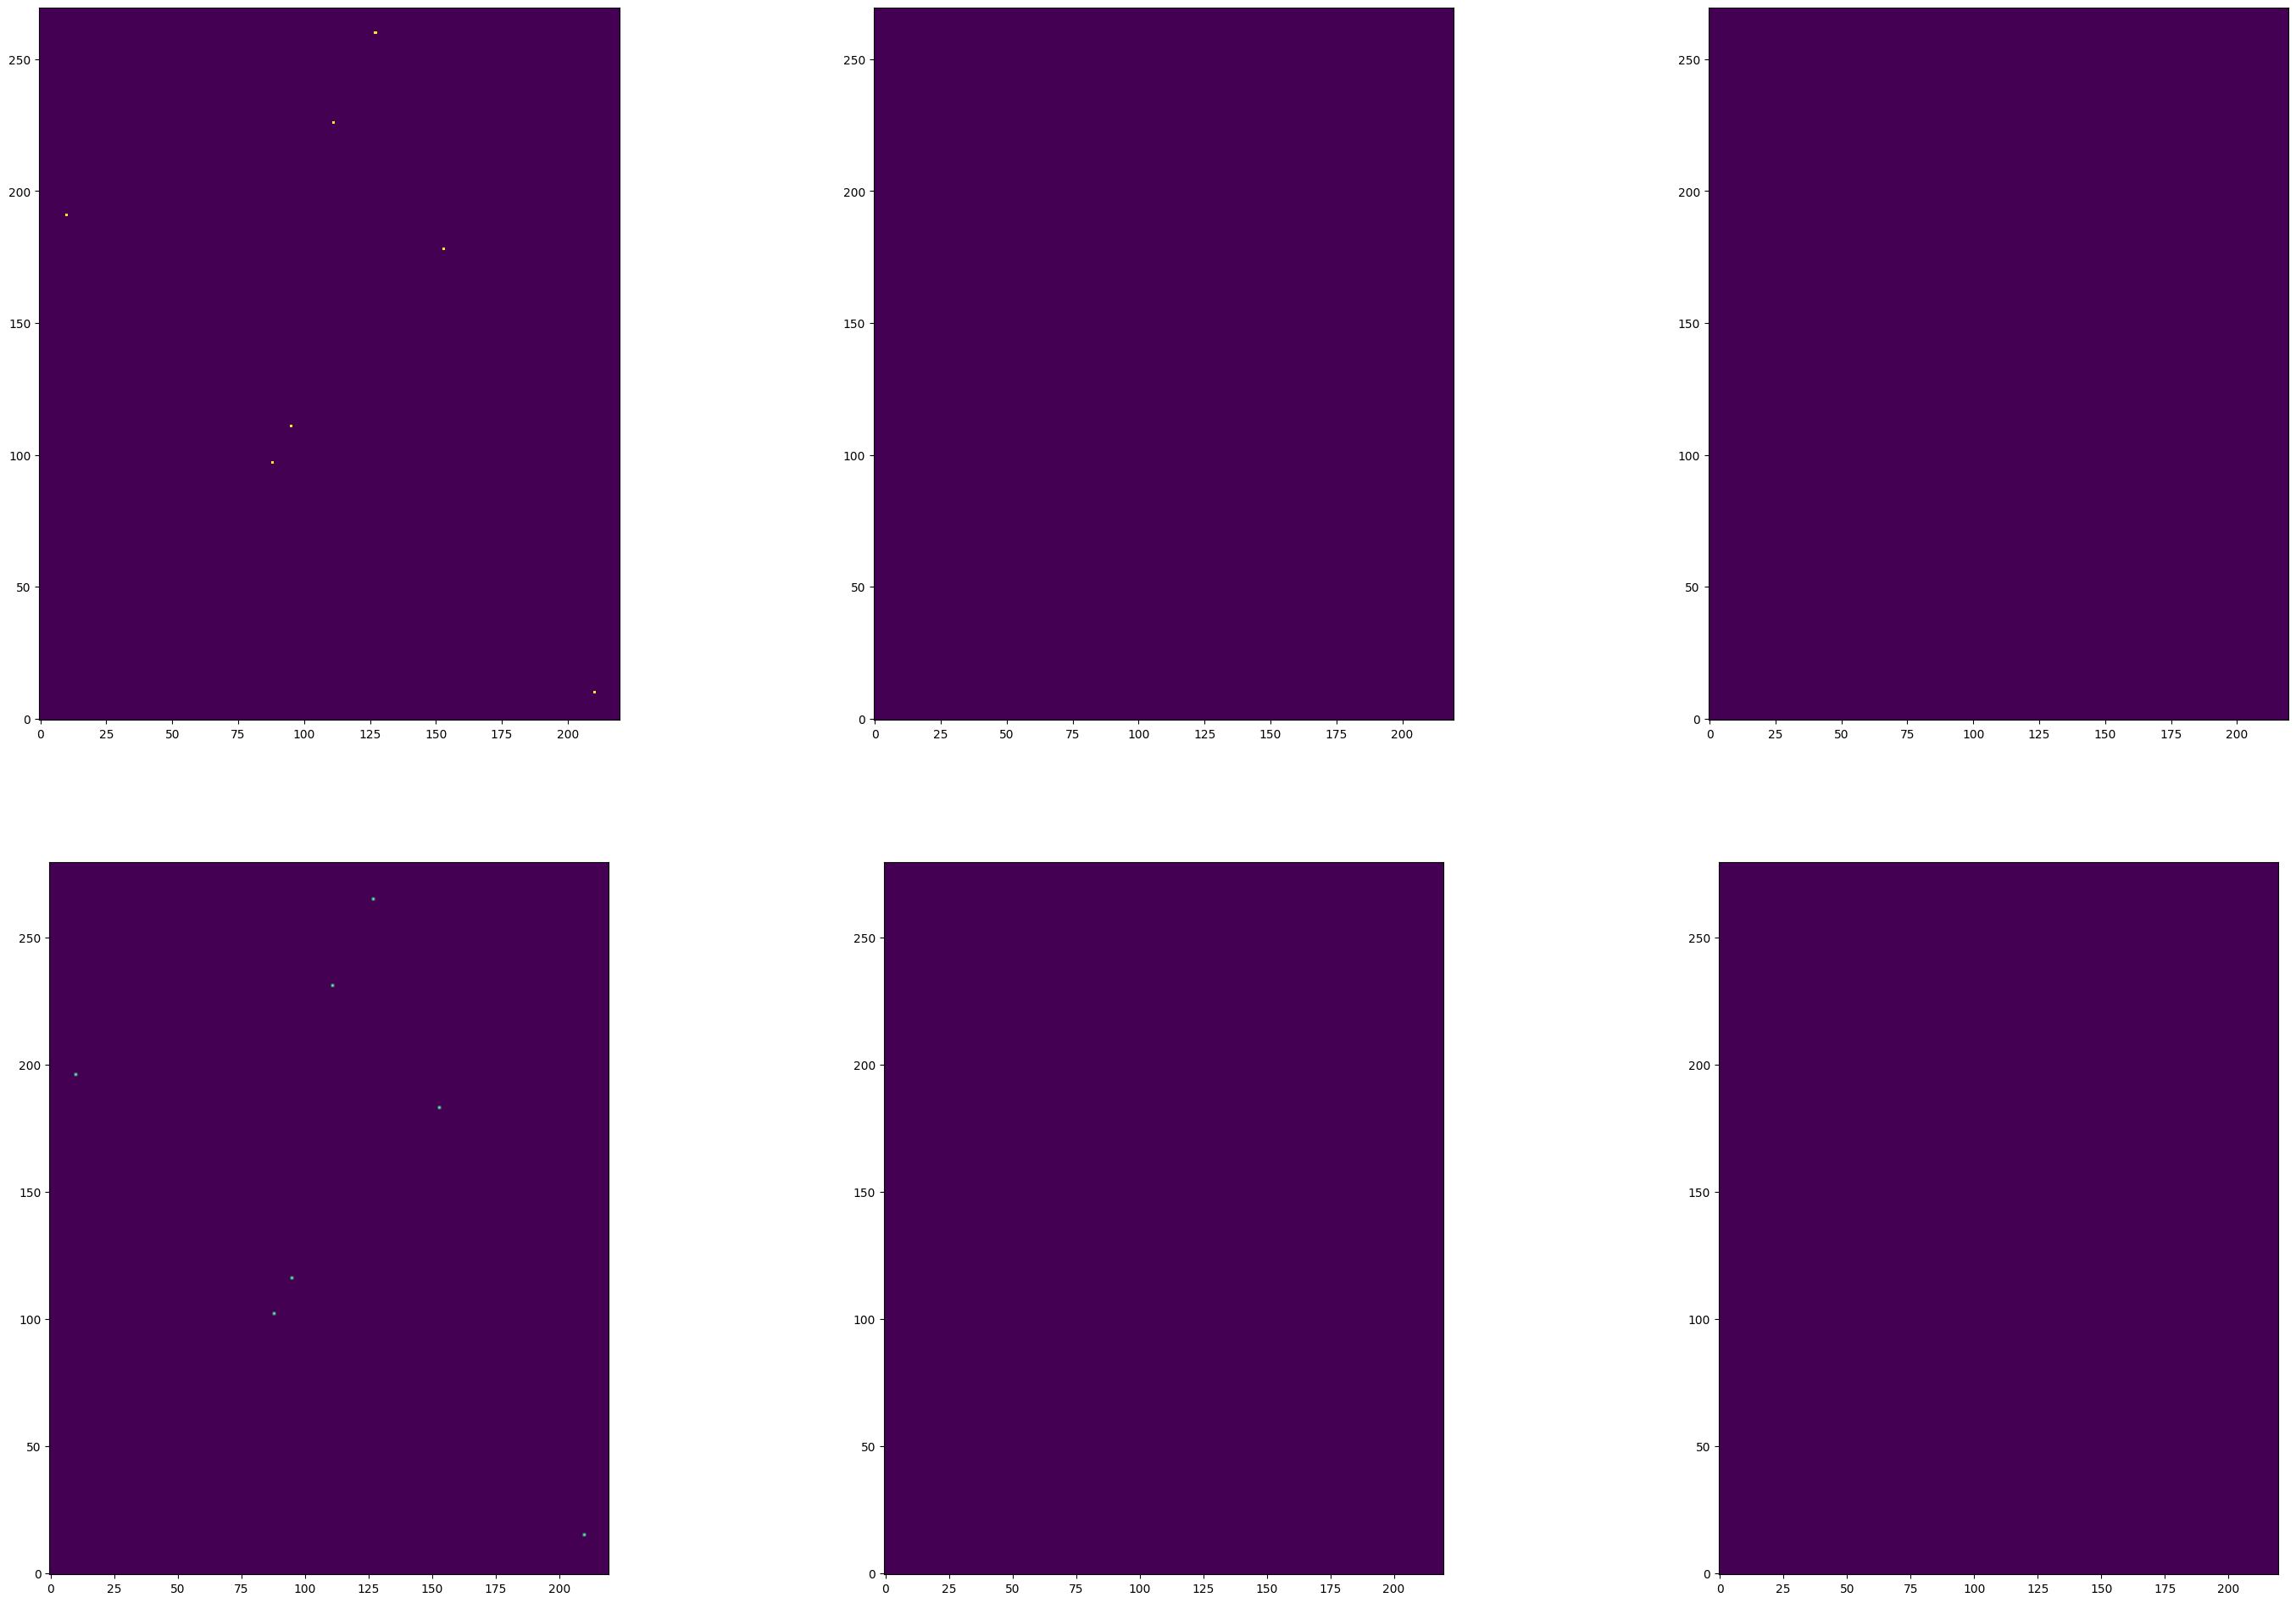

In [7]:
# plt.figure(figsize=(8,10))

fig, ax = plt.subplots(2,3,figsize=(36,24))

for i, filename in enumerate(filenames1[:3]) :
    if filename.endswith('.npy') and os.path.isfile(os.path.join(directory1, filename)):
        new_test = np.load(directory1+'/'+filename)
        print(new_test.shape)
        new_array = np.zeros((280, 220))
        new_array[5:275,:220] = new_test
        print(new_array.shape)
        ax[0][i].imshow(new_test, cmap='viridis',origin='lower')
        ax[1][i].imshow(new_array, cmap='viridis',origin='lower')

plt.show()

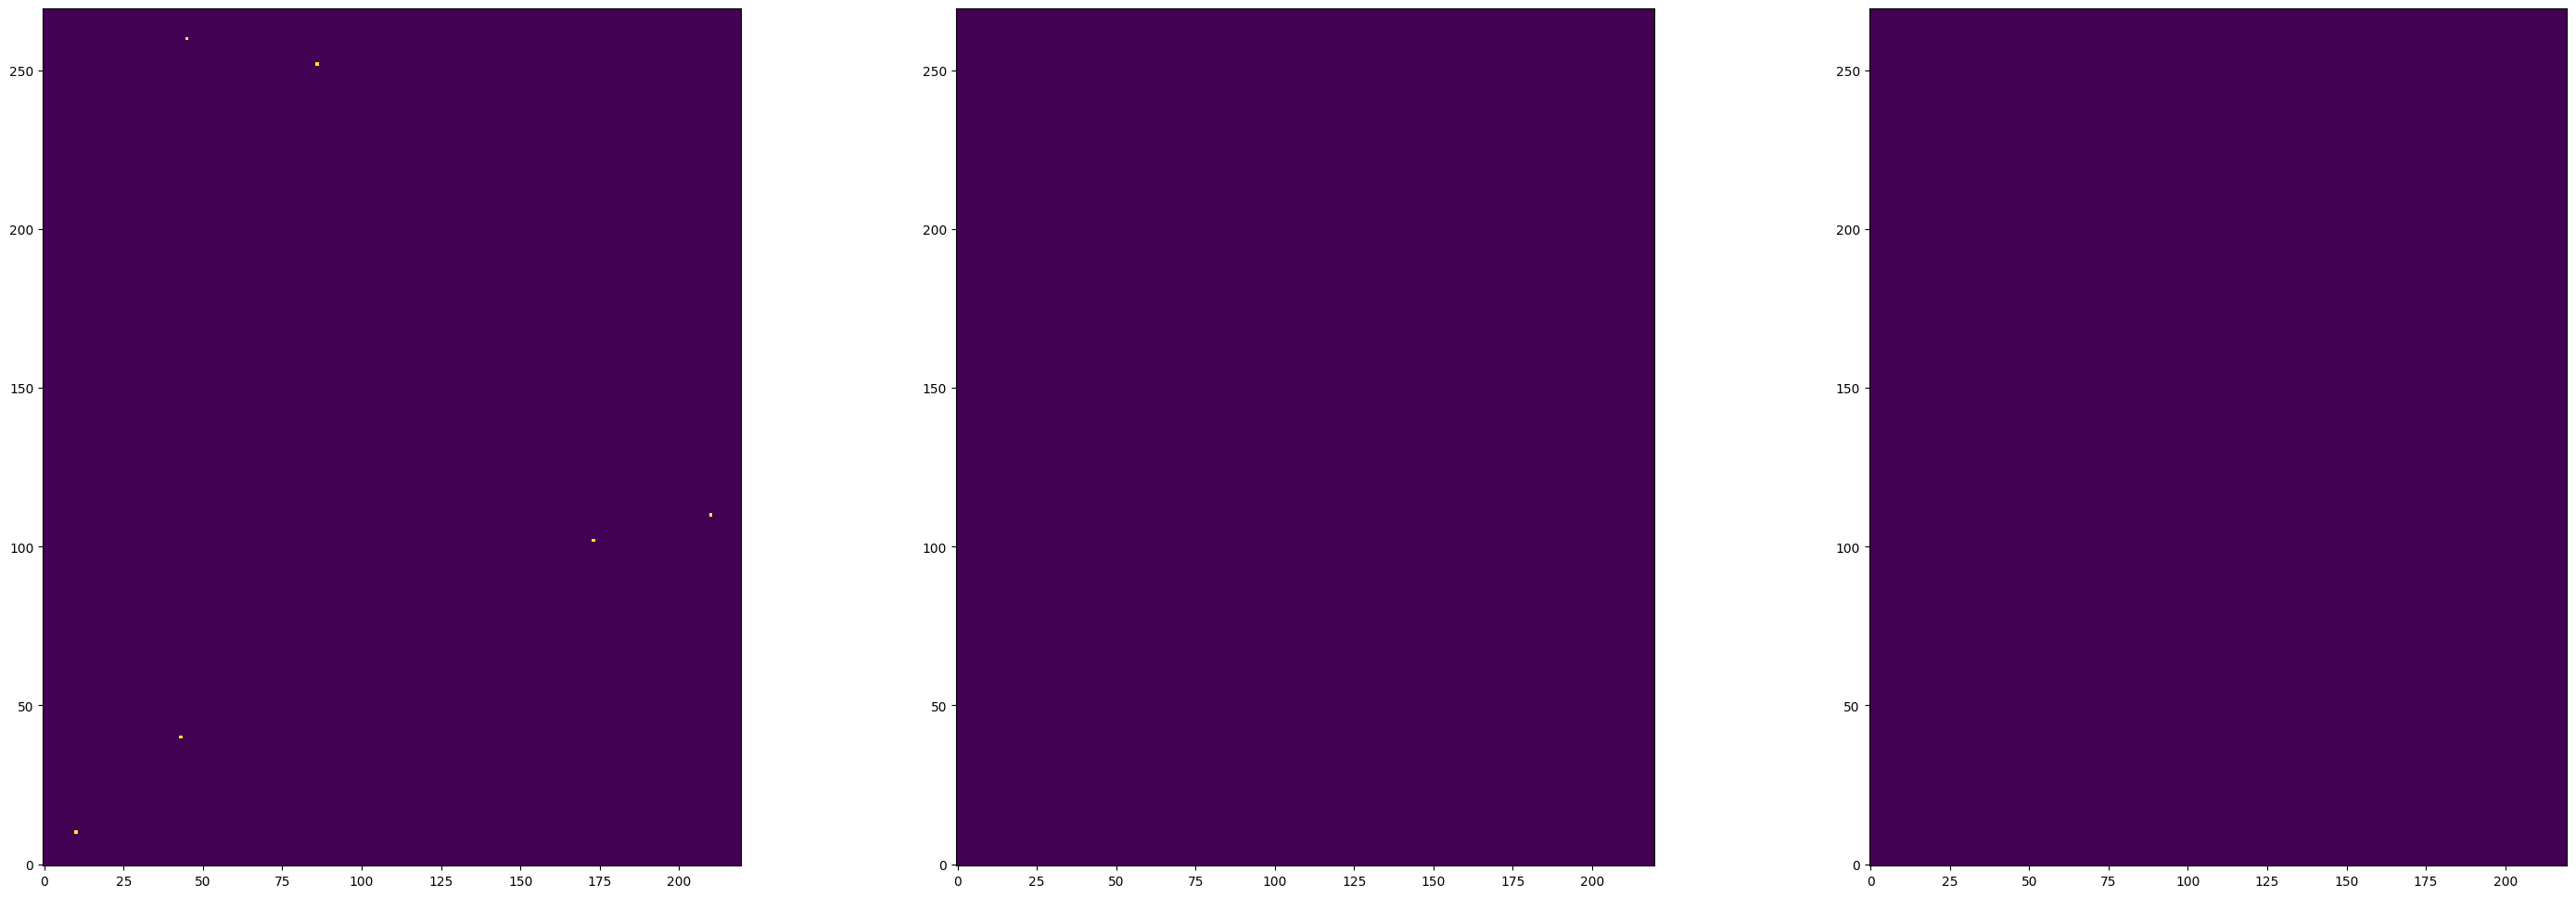

In [8]:
# load datapoints to tensor
# plt.figure(figsize=(8,10))

fig, ax = plt.subplots(1,3,figsize=(36,12))
for i, filename in enumerate(filenames3[:3]) :
    if filename.endswith('.npy') and os.path.isfile(os.path.join(directory3, filename)):
        new_test = np.load(directory3+'/'+filename)   
        ax[i].imshow(new_test, cmap='viridis',origin='lower')

plt.show()

In [9]:
# load datapoints to tensor
data_507 = []

for i, filename in enumerate(filenames1) :
    if filename.endswith('.npy') and os.path.isfile(os.path.join(directory1, filename)):
        new_test = np.load(directory1+'/'+filename)
        new_array = np.zeros((280, 220))
        new_array[5:275,:220] = new_test
        data_507.append(new_array)
data_507 = np.array(data_507)
data_507 = data_507[:,np.newaxis,:]
data_507.shape

(33538, 1, 280, 220)

In [10]:
# load datapoints to tensor
data_672 = []

for i, filename in enumerate(filenames2) :
    if filename.endswith('.npy') and os.path.isfile(os.path.join(directory2, filename)):
        new_test = np.load(directory2+'/'+filename)
        new_array = np.zeros((280, 220))
        new_array[5:275,:220] = new_test
        data_672.append(new_array)
data_672 = np.array(data_672)
data_672 = data_672[:,np.newaxis,:]
data_672.shape

(33538, 1, 280, 220)

In [11]:
# load datapoints to tensor
data_673 = []

for i, filename in enumerate(filenames3) :
    if filename.endswith('.npy') and os.path.isfile(os.path.join(directory3, filename)):
        new_test = np.load(directory3+'/'+filename)
        new_array = np.zeros((280, 220))
        new_array[5:275,:220] = new_test
        data_673.append(new_array)
data_673 = np.array(data_673)
data_673 = data_673[:,np.newaxis,:]
data_673.shape

(33538, 1, 280, 220)

In [12]:
dataset_all = np.concatenate((data_507, data_672, data_673))
dataset_all.shape

(100614, 1, 280, 220)

In [13]:
print(len(filenames1))
print(len(filenames2))
print(len(filenames3))

33538
33538
33538


In [14]:
df_151507.shape

(33538, 4226)

In [15]:
# dats = np.expand_dims(data_507[0],axis=0)
# dats2 = data_507[:,np.newaxis,:]
# print(dats.shape)
# print(dats2.shape)

In [16]:
# dataset_all = dataset[:,np.newaxis,:]
# dataset_all.shape

In [17]:
BATCH = ['507']*len(filenames1) + ['672']*len(filenames2) + ['673']*len(filenames3)
BATCH = np.array(BATCH)
BATCH.shape

(100614,)

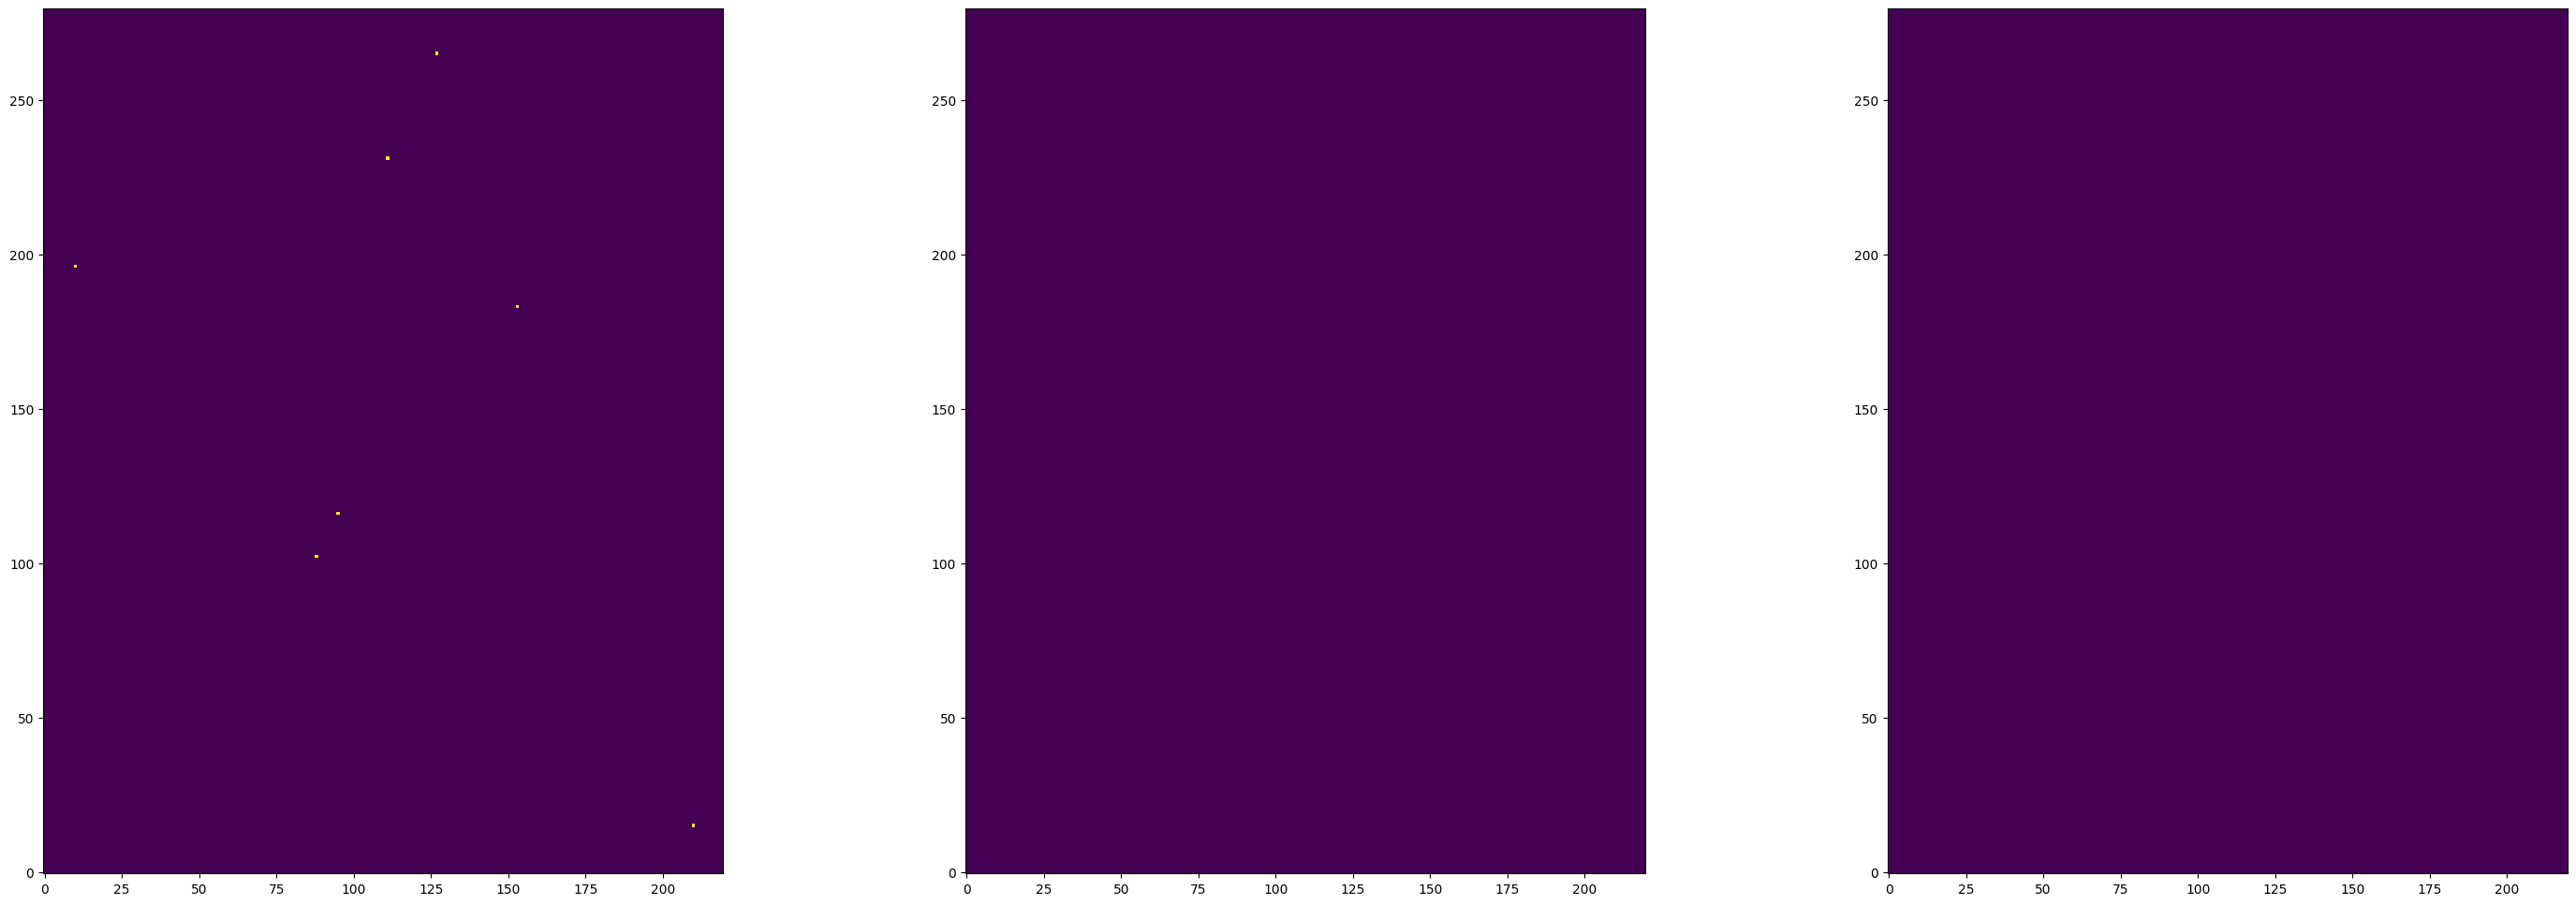

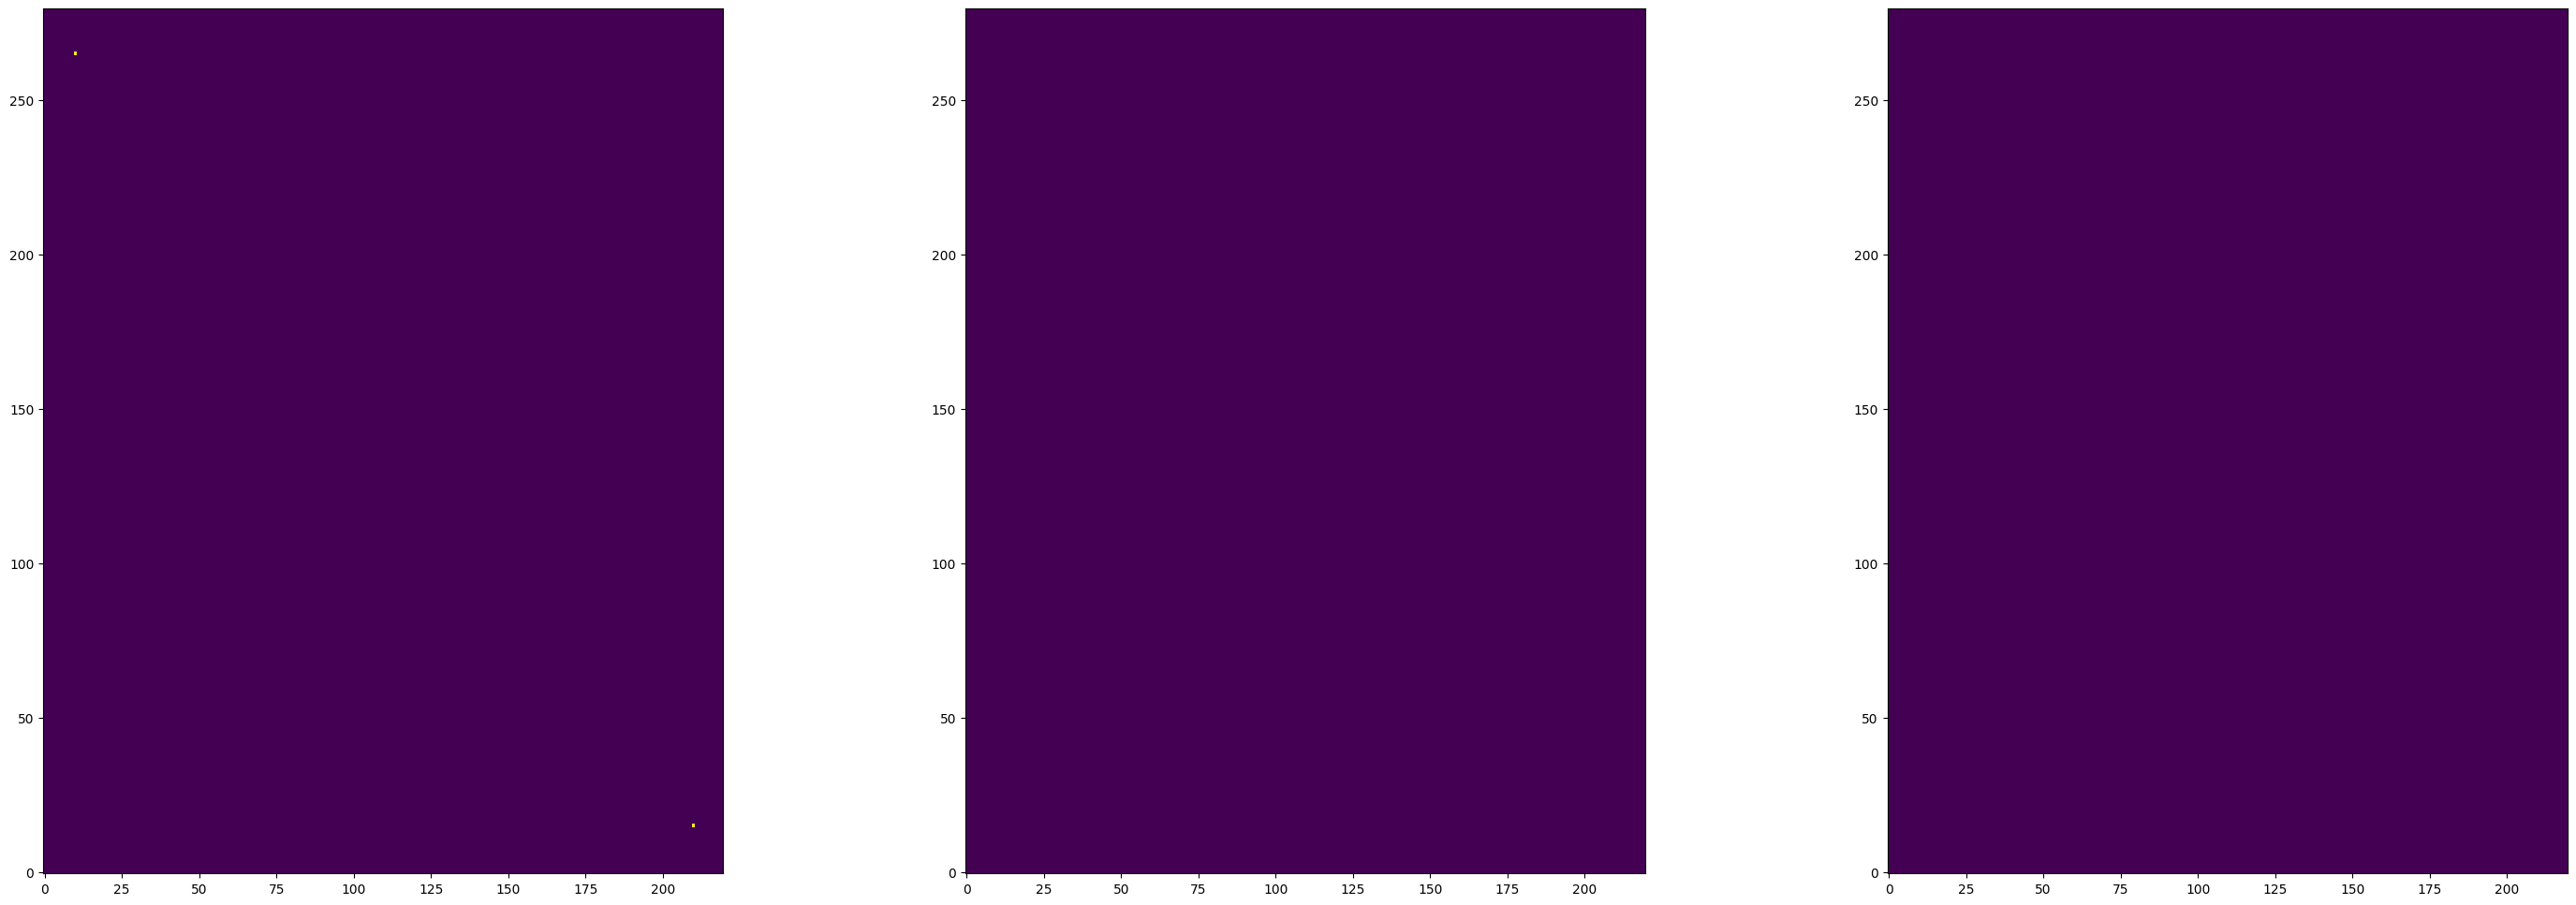

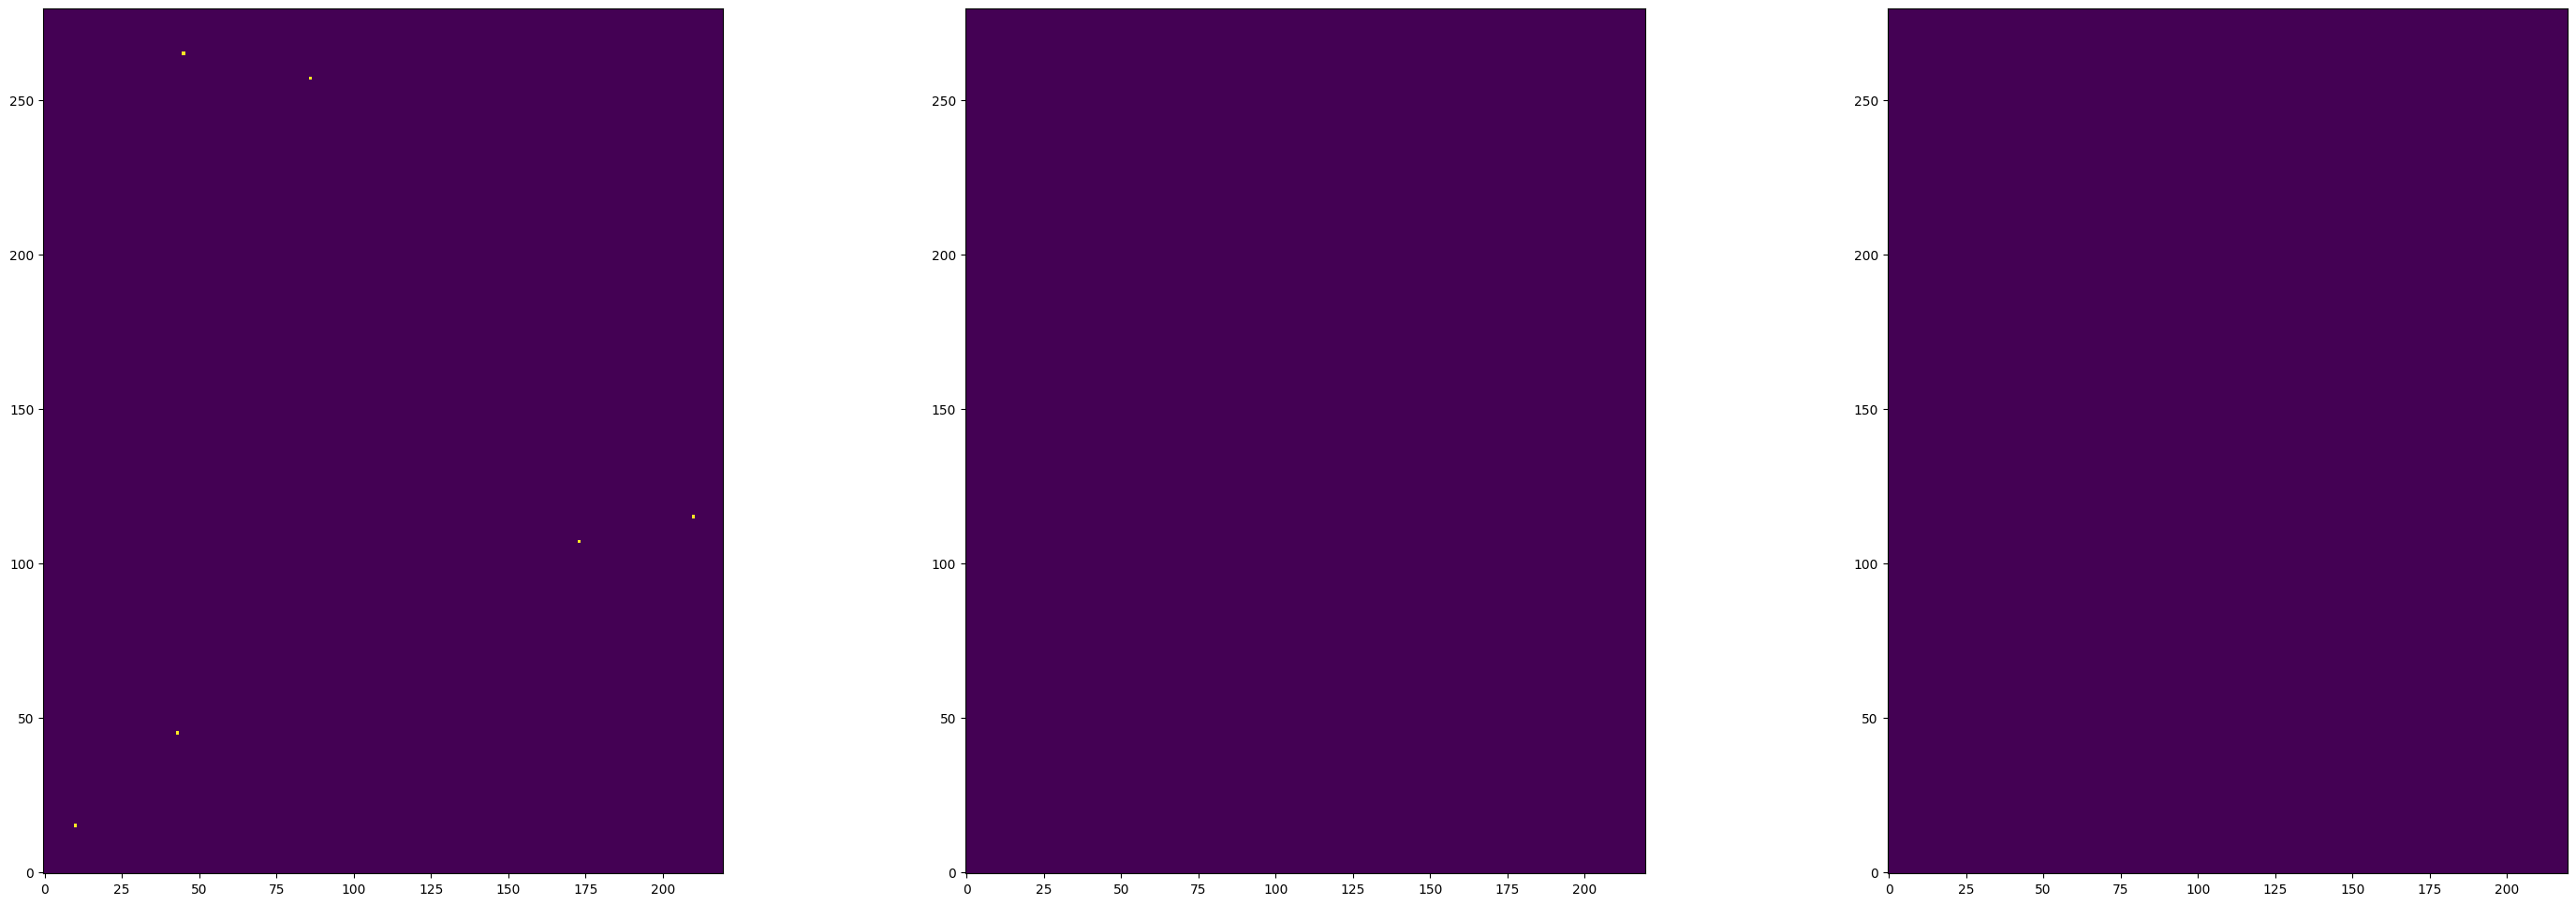

In [18]:
fig, ax = plt.subplots(1,3,figsize=(36,12))
for i, filename in enumerate(data_507[:3]) :
    ax[i].imshow(filename.squeeze(), cmap='viridis',origin='lower')
plt.show()

fig, ax = plt.subplots(1,3,figsize=(36,12))
for i, filename in enumerate(data_672[:3]) :
    ax[i].imshow(filename.squeeze(), cmap='viridis',origin='lower')
plt.show()

fig, ax = plt.subplots(1,3,figsize=(36,12))
for i, filename in enumerate(data_673[:3]) :
    ax[i].imshow(filename.squeeze(), cmap='viridis',origin='lower')
plt.show()

In [19]:
# fig, ax = plt.subplots(1,3,figsize=(36,12))
# for i, filename in enumerate(dataset_all[:3]) :
#     ax[i].imshow(filename.squeeze(), cmap='viridis',origin='lower')
# plt.show()

In [20]:
import sys
print(sys.getsizeof(new_test.astype(int)))
print(sys.getsizeof(new_test))

475328
59528


<h1>Feed to NN

In [21]:
df_151507.shape

(33538, 4226)

In [22]:
data_673.shape

(33538, 1, 280, 220)

In [23]:
# NN take matrix of gene distribution
dataset_active = data_673 #dataset_all, data_507, data_672, data_673
gene_size = 1000 #combined_all.shape[0](com1), combined_all.shape[1](com2), df_{active}.shape[1](com3)
print('Hidden Layer: ',gene_size) 
print('Dataset: ', dataset_active.shape)
print('Label: ', BATCH.shape)

Hidden Layer:  1000
Dataset:  (33538, 1, 280, 220)
Label:  (100614,)


In [24]:
sample_id = 'unfil_151673'

os.environ["CUDA_VISIBLE_DEVICES"]="1"

train_root_path = '/home/spatial_integration/dataset/datapoints/'+sample_id 
test_root_path = '/home/spatial_integration/dataset/datapoints/'+sample_id 
batch_size = 200
epochs = 100
learning_rate = 1e-3
im_size = dataset_active[0].shape
# torch.manual_seed(42)

In [25]:
instance_X_train, instance_X_test = train_test_split(dataset_active, test_size=0.30, random_state=42,shuffle=True) 


train_dataset = TumorDatasetTrain(instance=instance_X_train, root_dir=train_root_path,
                                transform=transforms.Compose([ToTensor()]))
test_dataset = TumorDatasetTest(instance=instance_X_test, root_dir=test_root_path, 
                                transform=transforms.Compose([ToTensor()]))
all_dataset = TumorDatasetAll(instance=dataset_all, root_dir=train_root_path,
                                transform=transforms.Compose([ToTensor()]))

dataloader_all = DataLoader(all_dataset, batch_size=batch_size, shuffle=False, num_workers=1)
dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

running_loss = []
running_vloss = []

In [26]:
now = datetime.now()
cur_time = now.strftime("%Y-%m-%d_%H:%M:%S")

In [27]:
model_path1 = "weights/cnn673_2023-08-24_01.pth"
save = False
pret = False

In [28]:
if os.path.exists(model_path1):
    print("File exists!")
else:
    print("saving to: '{}'".format(model_path1))

saving to: 'weights/cnn673_2023-08-24_01.pth'


In [29]:
size = list(im_size)
print(size)
print(np.prod(size))

[1, 280, 220]
61600


In [32]:
class GraphAutoencoder(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(GraphAutoencoder, self).__init__()
        self.conv1 = dgl.nn.GraphConv(in_feats, hidden_feats)
        self.conv2 = dgl.nn.GraphConv(hidden_feats, out_feats)
        self.conv3 = dgl.nn.GraphConv(out_feats, hidden_feats)
        self.conv4 = dgl.nn.GraphConv(hidden_feats, in_feats)

    def forward(self, g, features):
        h = F.relu(self.conv1(g, features))
        h = self.conv2(g, h)
        g.ndata['h'] = h
        h = F.relu(self.conv3(g, h))
        h = self.conv4(g, h)
        return h

class Conv_Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(1024, 128)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        print(x.shape)
        x = F.relu(self.conv2(x))
        print(x.shape)
        x = x.view(-1, 1024)
        x = F.relu(self.fc1(x))
        return x

# Define the decoder network.
class Conv_Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.fc1 = nn.Linear(128, 1024)
        self.conv1 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = x.view(-1, 16, 16, 16)
        x = F.relu(self.conv1(x))
        x = F.sigmoid(self.conv2(x))
        return x
    
class AE(nn.Module):
    def __init__(self, input_shape, hidden_shape):
        super().__init__()
        self.encoder=nn.Sequential(
            nn.Linear(input_shape,512),
            nn.ReLU(True),
            nn.Linear(512,1024),
            nn.ReLU(True),
            nn.Linear(1024,2048),
            nn.ReLU(True),
            nn.Linear(2048,4096),
            nn.ReLU(True),
            nn.Linear(4096,4096),
            nn.ReLU(True),
            nn.Linear(4096,hidden_shape)
            )

        self.decoder=nn.Sequential(
            nn.Linear(hidden_shape,4096),
            nn.ReLU(True),
            nn.Linear(4096,4096),
            nn.ReLU(True),
            nn.Linear(4096,2048),
            nn.ReLU(True),
            nn.Linear(2048,1024),
            nn.ReLU(True),
            nn.Linear(1024,512),
            nn.ReLU(True),
            nn.Linear(512,input_shape)
            )

    def forward(self,x):
        code = torch.sigmoid(self.encoder(x))
        rep = torch.sigmoid(self.decoder(code))
        return rep, code

class ConvAutoencoder(nn.Module):
    def __init__(self, hidden_shape):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 33 --> 16), 2x2 kernels
        self.conv1 = nn.Conv2d(1, 16, 3, stride=1, padding=1)  
        # conv layer (depth from 16 --> 4), 2x2 kernels
        self.conv2 = nn.Conv2d(16, 16, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 1, 3, stride=1, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        # linear for decoder output
        # self.fc1 = nn.Linear(4*71*56, hidden_shape)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(1, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 16, 3, stride=1)
        self.t_conv3 = nn.ConvTranspose2d(16, 1, 2, stride=2, padding=4)

        self.upsam = nn.Upsample(scale_factor=2)

    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        # add second hidden layer
        x = F.relu(self.conv2(x))
        # x = self.pool(x)

        x = F.relu(self.conv2(x))
        # x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x1 = self.pool(x)  # compressed representation
        # x = x.view(-1,)
        # x1 = self.fc1(x)
        
        # print('conv1: ', x.shape)
        # print('conv2: ', x.shape)
        # print('conv2-1: ', x.shape)
        # print('conv3: ', x1.shape)
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x1))
        # x = self.upsam(x)
        
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
        # x = self.upsam(x)
        

        x = F.sigmoid(self.t_conv2(x))
        # x = self.upsam(x)
        
        
        x = F.relu(self.t_conv3(x))
        # x = self.upsam(x)
        # print('convT1: ', x.shape)
        # print('convT2: ', x.shape)
        # print('convT2-1: ', x.shape)
        # print('convT3: ', x.shape)
        return x,x1

In [33]:
device = torch.device("cuda")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
# model = ConvAutoencoder().to(device)
model = ConvAutoencoder(gene_size).to(device)
model.double()

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (t_conv3): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2), padding=(4, 4))
  (upsam): Upsample(scale_factor=2.0, mode='nearest')
)

In [34]:
#  use gpu if available
start_time1 = time.time()

# device = torch.device("cuda")

# # create a model from `AE` autoencoder class
# # load it to the specified device, either gpu or cpu
# # model = ConvAutoencoder().to(device)
# model = AE(input_shape=np.prod(size), hidden_shape=gene_size).to(device)
# model.double()

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# mean-squared error loss
criterion = nn.MSELoss()
running_loss = []
running_vloss = []

#     Auto Encoder Training
if (not os.path.exists(model_path1) or not pret):
    print('Training AE')
    for epoch in range(epochs):
        start_time = time.time()
        loss = 0
        vloss = 0
        model.train()
        for batch_ndx, batch_features in enumerate(dataloader_train):
            # reshape mini-batch data to [N, 784] matrix
            # load it to the active device
    #             batch_features = Variable(batch_features['image']).to(device)
    #             batch_features = batch_features.type(torch.cuda.FloatTensor)
            images = Variable(batch_features['image']).to(device)
            images = images.double()
    #             images = images.type(torch.cuda.FloatTensor)
            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimizer.zero_grad()

            # compute reconstructions
            outputs, coded = model(images)
#             print('size', outputs.size(), coded.size())
    #             encoder_only_nosig = model.encoder(images)
    #             encoder_only = torch.sigmoid(model.encoder(images))
            # compute training reconstruction loss
            train_loss = criterion(outputs, images)

            # compute accumulated gradients
            train_loss.backward()

            # perform parameter update based on current gradients
            optimizer.step()
            # add the mini-batch training loss to epoch loss
            loss += train_loss.item()

        # compute the epoch training loss
        loss = loss / len(dataloader_train)
        running_loss.append(loss)
        # display the epoch training loss
        #if(epoch % 5 == 0):
    #       ------------------------------------------------------------------------  
        model.eval()
        with torch.no_grad():
            for batch_ndx, batch_features in enumerate(dataloader_test):
                # reshape mini-batch data to [N, 784] matrix
                # load it to the active device
    #             batch_features = Variable(batch_features['image']).to(device)
    #             batch_features = batch_features.type(torch.cuda.FloatTensor)
                images = Variable(batch_features['image']).to(device)
                images = images.double()
    #                 images = images.type(torch.cuda.FloatTensor)
                # reset the gradients back to zero
                # PyTorch accumulates gradients on subsequent backward passes
                # optimizer.zero_grad()

                # compute reconstructions
                outputs, coded = model(images)
    #             encoder_only_nosig = model.encoder(images)
    #             encoder_only = torch.sigmoid(model.encoder(images))
                # compute training reconstruction loss
                valid_loss = criterion(outputs, images)

                # perform parameter update based on current gradients
    #                 optimizer.step()
                # add the mini-batch training loss to epoch loss
                vloss += valid_loss.item()

            # compute the epoch training loss
            vloss = vloss / len(dataloader_test)
            running_vloss.append(vloss)

    #     -----------------------------------------------------------------------------
        current_time = time.time()
        elapsed_time = current_time - start_time
        print("epoch : {}/{}, recon loss = {:.8f}, valid loss = {:.8f}, time = {:.2f}s".format(epoch + 1, epochs, loss, vloss, elapsed_time))


        if (epoch > 3) and (abs(running_vloss[epoch] - running_vloss[epoch-1]) <= 0.0001) and (abs(running_vloss[epoch - 1] - running_vloss[epoch - 2]) <= 0.0001):
            print('satisfied early stop')
            break
    if save:
        torch.save(model.state_dict(), model_path1)
        print('saved to:', model_path1)
else:
    print("loading from file")
    model.load_state_dict(torch.load(model_path1))
    model.eval()
    loss = 0
    vloss = 0
    with torch.no_grad():
        for batch_ndx, batch_features in enumerate(dataloader_test):
            # reshape mini-batch data to [N, 784] matrix
            # load it to the active device
#             batch_features = Variable(batch_features['image']).to(device)
#             batch_features = batch_features.type(torch.cuda.FloatTensor)
            images = Variable(batch_features['image']).view(-1,np.prod(size)).to(device)
            images = images.double()
#                 images = images.type(torch.cuda.FloatTensor)
            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            # optimizer.zero_grad()

            # compute reconstructions
            outputs, coded = model(images)
#             encoder_only_nosig = model.encoder(images)
#             encoder_only = torch.sigmoid(model.encoder(images))
            # compute training reconstruction loss
            valid_loss = criterion(outputs, images)

            # perform parameter update based on current gradients
#                 optimizer.step()
            # add the mini-batch training loss to epoch loss
            vloss += valid_loss.item()

        # compute the epoch training loss
        vloss = vloss / len(dataloader_test)
        running_vloss.append(vloss)

    #     -----------------------------------------------------------------------------
    print("valid loss = {:.8f}".format(vloss))
    
print("--- %s seconds ---" % (time.time() - start_time1))

Training AE
epoch : 1/100, recon loss = 0.35960610, valid loss = 0.29394160, time = 5.83s
epoch : 2/100, recon loss = 0.27375526, valid loss = 0.21784373, time = 3.32s
epoch : 3/100, recon loss = 0.20205484, valid loss = 0.15549906, time = 3.32s
epoch : 4/100, recon loss = 0.14197850, valid loss = 0.10608573, time = 3.32s
epoch : 5/100, recon loss = 0.09585559, valid loss = 0.06771368, time = 3.33s
epoch : 6/100, recon loss = 0.06221731, valid loss = 0.04297224, time = 3.35s
epoch : 7/100, recon loss = 0.03809570, valid loss = 0.02396030, time = 3.36s
epoch : 8/100, recon loss = 0.02211939, valid loss = 0.01344793, time = 3.35s
epoch : 9/100, recon loss = 0.01334275, valid loss = 0.00772754, time = 3.33s
epoch : 10/100, recon loss = 0.00572861, valid loss = 0.00463612, time = 3.36s
epoch : 11/100, recon loss = 0.00428679, valid loss = 0.00328461, time = 3.36s
epoch : 12/100, recon loss = 0.00342689, valid loss = 0.00441826, time = 3.33s
epoch : 13/100, recon loss = 0.00459225, valid lo

saving to: 'Training_loss_cnn673_230824_02.png'


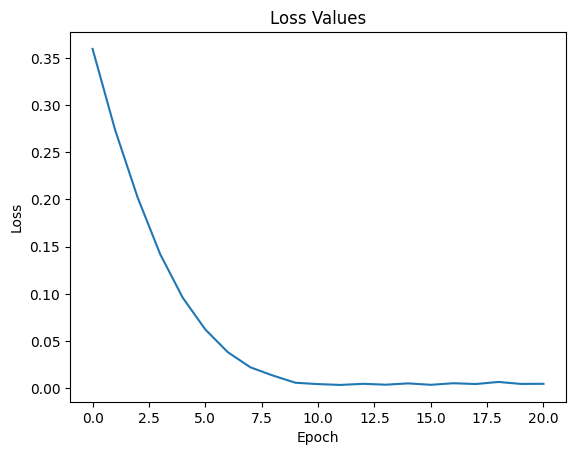

In [35]:
plot_path = 'Training_loss_cnn673_230824_02.png'
if (not pret):
    plt.plot(running_loss)
    
    # Set the title of the plot
    plt.title("Loss Values")
    
    # Set the x-axis label
    plt.xlabel("Epoch")
    
    # Set the y-axis label
    plt.ylabel("Loss")
    
    # save plot
    if os.path.exists(plot_path):
        print("File exists!")
    else:
        print("saving to: '{}'".format(plot_path))
        plt.savefig(plot_path)
    
    # Show the plot
    plt.show()

saving to: 'Validation_loss_cnn673_230824_02.png'


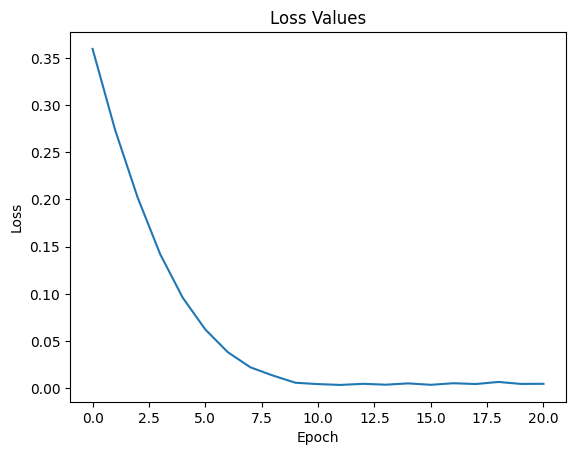

In [36]:
plot_path = 'Validation_loss_cnn673_230824_02.png'
if (not pret):
    plt.plot(running_loss)
    
    # Set the title of the plot
    plt.title("Loss Values")
    
    # Set the x-axis label
    plt.xlabel("Epoch")
    
    # Set the y-axis label
    plt.ylabel("Loss")
    
    # save plot
    if os.path.exists(plot_path):
        print("File exists!")
    else:
        print("saving to: '{}'".format(plot_path))
        plt.savefig(plot_path)
    
    # Show the plot
    plt.show()

In [53]:
run = True
data = dataset_active #data_507, data_672, data_673, dataset_all, dataset_active

# model.load_state_dict(torch.load(model_path1))
model.eval()    


loss = 0
vloss = 0
coded_list = []

if run:
        for instance in tqdm(data):
        
                image = torch.from_numpy(instance)

                with torch.no_grad():
                        # for batch_ndx, batch_features in enumerate(dataloader_all):
                        # reshape mini-batch data to [N, 784] matrix
                        # load it to the active device
                #             batch_features = Variable(batch_features['image']).to(device)
                #             batch_features = batch_features.type(torch.cuda.FloatTensor)
                        images = Variable(image).to(device)
                        images = images.double()
                #                 images = images.type(torch.cuda.FloatTensor)
                        # reset the gradients back to zero
                        # PyTorch accumulates gradients on subsequent backward passes
                        # optimizer.zero_grad()

                        # compute reconstructions
                        outputs, coded = model(images)
                        coded_list.append(coded)
                #             encoder_only_nosig = model.encoder(images)
                #             encoder_only = torch.sigmoid(model.encoder(images))
                        # compute training reconstruction loss
                        valid_loss = criterion(outputs, images)

                        # perform parameter update based on current gradients
                #                 optimizer.step()
                        # add the mini-batch training loss to epoch loss
                        vloss += valid_loss.item()

        # compute the epoch training loss
        vloss = vloss / len(data)
        running_vloss.append(vloss)
        #     -----------------------------------------------------------------------------
        print("valid loss = {:.8f}".format(vloss))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 33538/33538 [09:35<00:00, 58.28it/s]

valid loss = 0.02362976


In [37]:
run = True
data = dataset_active #data_507, data_672, data_673, dataset_all, dataset_active

# model.load_state_dict(torch.load(model_path1))
model.eval()    


loss = 0
vloss = 0
coded_list = []

if run:
        for instance in tqdm(data):
        
                image = torch.from_numpy(instance)

                with torch.no_grad():
                        # for batch_ndx, batch_features in enumerate(dataloader_all):
                        # reshape mini-batch data to [N, 784] matrix
                        # load it to the active device
                #             batch_features = Variable(batch_features['image']).to(device)
                #             batch_features = batch_features.type(torch.cuda.FloatTensor)
                        images = Variable(image).to(device)
                        images = images.double()
                #                 images = images.type(torch.cuda.FloatTensor)
                        # reset the gradients back to zero
                        # PyTorch accumulates gradients on subsequent backward passes
                        # optimizer.zero_grad()

                        # compute reconstructions
                        outputs, coded = model(images)
                        coded_list.append(coded)
                #             encoder_only_nosig = model.encoder(images)
                #             encoder_only = torch.sigmoid(model.encoder(images))
                        # compute training reconstruction loss
                        valid_loss = criterion(outputs, images)

                        # perform parameter update based on current gradients
                #                 optimizer.step()
                        # add the mini-batch training loss to epoch loss
                        vloss += valid_loss.item()

        # compute the epoch training loss
        vloss = vloss / len(data)
        running_vloss.append(vloss)
        #     -----------------------------------------------------------------------------
        print("valid loss = {:.8f}".format(vloss))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 33538/33538 [09:38<00:00, 57.99it/s]

valid loss = 0.00388191


In [39]:
run = True
data = dataset_active #data_507, data_672, data_673, dataset_all, dataset_active

# model.load_state_dict(torch.load(model_path1))
model.eval()    


loss = 0
vloss = 0
coded_list = []

if run:
        for instance in tqdm(data):
        
                image = torch.from_numpy(instance)

                with torch.no_grad():
                        # for batch_ndx, batch_features in enumerate(dataloader_all):
                        # reshape mini-batch data to [N, 784] matrix
                        # load it to the active device
                #             batch_features = Variable(batch_features['image']).to(device)
                #             batch_features = batch_features.type(torch.cuda.FloatTensor)
                        images = Variable(image).view(-1,np.prod(size)).to(device)
                        images = images.double()
                #                 images = images.type(torch.cuda.FloatTensor)
                        # reset the gradients back to zero
                        # PyTorch accumulates gradients on subsequent backward passes
                        # optimizer.zero_grad()

                        # compute reconstructions
                        outputs, coded = model(images)
                        coded_list.append(coded)
                #             encoder_only_nosig = model.encoder(images)
                #             encoder_only = torch.sigmoid(model.encoder(images))
                        # compute training reconstruction loss
                        valid_loss = criterion(outputs, images)

                        # perform parameter update based on current gradients
                #                 optimizer.step()
                        # add the mini-batch training loss to epoch loss
                        vloss += valid_loss.item()

        # compute the epoch training loss
        vloss = vloss / len(data)
        running_vloss.append(vloss)
        #     -----------------------------------------------------------------------------
        print("valid loss = {:.8f}".format(vloss))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 33538/33538 [01:11<00:00, 469.31it/s]

valid loss = 0.00354289


In [38]:
np_coded_list = np.array([tensor.cpu().numpy() for tensor in coded_list])
np_coded_list.shape

(33538, 1, 4226)

In [40]:
np_coded_list = np.array([tensor.cpu().numpy() for tensor in coded_list])
np_coded_list.shape

(33538, 1, 3639)

In [38]:
np_coded_list = np.array([tensor.cpu().numpy() for tensor in coded_list])
np_coded_list.shape

(33538, 1, 4015)

In [38]:
np_coded_list = np.array([tensor.cpu().numpy() for tensor in coded_list])
np_coded_list.shape

(33538, 1, 1000)

In [54]:
np_coded_list = np.array([tensor.cpu().numpy() for tensor in coded_list])
np_coded_list.shape

(33538, 4, 71, 56)

In [38]:
np_coded_list = np.array([tensor.cpu().numpy() for tensor in coded_list])
np_coded_list.shape

(33538, 4, 70, 55)

In [61]:
torch.flatten(coded_list[0]).shape

torch.Size([15904])

In [67]:
coded_list[0].view(1,-1,).shape

torch.Size([1, 15904])

In [39]:
print(np_coded_list.shape)
coded_path = 'dataset/datapoints/cnn_com4m_encoded_673_unfil.npy'
if os.path.exists(coded_path):
    print("{} file exists!".format(coded_path))
else:
    print("saving to: '{}'".format(coded_path))
    np.save(coded_path,np_coded_list)


(33538, 1, 1000)
saving to: 'dataset/datapoints/com4m_encoded_673_unfil.npy'


In [40]:
print("a")

a


In [44]:
coded_all.cpu().numpy()

array([[0.5123302 , 0.49262313, 0.50824453, ..., 0.50302137, 0.50108993,
        0.50447564],
       [0.5121361 , 0.49257998, 0.50827556, ..., 0.5030959 , 0.50095513,
        0.50433852],
       [0.5129166 , 0.4925728 , 0.50875393, ..., 0.50316882, 0.50178365,
        0.50464676],
       ...,
       [0.51222473, 0.4926974 , 0.5085071 , ..., 0.50307037, 0.50127857,
        0.50444283],
       [0.51351355, 0.49169263, 0.50941742, ..., 0.50198281, 0.50113547,
        0.50502596],
       [0.51804234, 0.49004454, 0.51321742, ..., 0.50223653, 0.50186079,
        0.50732488]])

: 

In [30]:
dataset_all[:10]

array([[[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]],


       [[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]],


       [[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False

In [60]:
coded.squeeze().cpu().numpy()

array([0.5130231 , 0.49275185, 0.50900661, ..., 0.50318205, 0.50187437,
       0.50493974])

In [37]:
outputs.shape

torch.Size([1, 59400])

In [123]:
coord_list = [[1.2, 3.4], [2.3, 4.5], [3.4, 5.6], [4.5, 6.7]]

# convert the list to a PyTorch tensor
coords = torch.tensor(coord_list)

# reshape the tensor to the required input shape (batch size, number of channels, height, width)
coords = coords.view(1, 1, -1, 2)

In [124]:
coords

tensor([[[[1.2000, 3.4000],
          [2.3000, 4.5000],
          [3.4000, 5.6000],
          [4.5000, 6.7000]]]])

<h1>Run BEER

In [ ]:
# get decoder hidden feature and concatenate with assays

# final matrix includes ~100 extra features of spatial embeddings treated as spots

# BEER should results in a Umap plot, Correlation plot, and no-Batch effect umap